In [13]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score

#from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
        
from numba import jit
from sklearn import metrics
import lightgbm as lgb
import time
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import KFold

In [2]:
train_transaction = pd.read_csv("/Users/wangjiaxin/Desktop/semester/data science for business/project/train_transaction.csv")
train_identity = pd.read_csv("/Users/wangjiaxin/Desktop/semester/data science for business/project/train_identity.csv")

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [3]:
train_df = train.sort_values('TransactionDT').loc[:472432,:].reset_index(drop = True)
test_df = train.sort_values('TransactionDT').loc[472432:,:].reset_index(drop = True)


In [4]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472428,3459428,0,12192736,49.000,W,17188,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472429,3459429,0,12192742,40.000,H,16659,170.0,150.0,visa,226.0,...,chrome 65.0,24.0,1440x900,match_status:2,T,F,T,T,desktop,MacOS
472430,3459430,0,12192743,15.000,W,7919,194.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472431,3459431,0,12192842,49.000,W,13749,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
many_null_cols = [col for col in train_df.columns if train_df[col].isnull().sum() / train_df.shape[0] > 0.9]
many_null_cols_test = [col for col in test_df.columns if test_df[col].isnull().sum() / test_df.shape[0] > 0.9]

print(f'{len(set(many_null_cols+ many_null_cols_test)) / train_df.shape[1]: .4f} % columns have more than 90% NaN values')


# Getting columns with single value appearing more than 90% of time

big_top_value_cols = [col for col in train_df.columns if train_df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test_df.columns if test_df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

print(f'{len(set(big_top_value_cols+ big_top_value_cols_test)) / train_df.shape[1]: .4f} % columns have more than 90% same values')


# Getting columns with no unique values

one_value_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]
one_value_cols_test = [col for col in test_df.columns if test_df[col].nunique() <= 1]

print(f'{len(set(one_value_cols+ one_value_cols_test))} columns have only 1 value')


cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
print(len(cols_to_drop))

train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

#dealing with numeric data, fill in with mean 
for col in train_df:
    if train_df[col].dtype != 'object':
        train_df[col] = train_df[col].fillna(train_df[col].mean())

for col in test_df:
    if test_df[col].dtype != 'object':
        test_df[col] = test_df[col].fillna(test_df[col].mean())
    
#dealing with categorical data, fill in with mode
for col in train_df:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].fillna(train_df[col].mode().iloc[0])

for col in test_df:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].fillna(test_df[col].mode().iloc[0])
        
#label encoder to make the categorical data suitable for the machine learning
for f in train_df.columns:
    if train_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values)) 
        
for f in test_df.columns:
    if test_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

 0.0369 % columns have more than 90% NaN values
 0.1797 % columns have more than 90% same values
1 columns have only 1 value
77


In [6]:
x_train = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = train_df.sort_values('TransactionDT')['isFraud']

In [7]:
y_test = test_df['isFraud']
x_test = test_df.drop(['TransactionDT', 'TransactionID', 'isFraud'], axis=1)

In [9]:
def plot_calibration_curve(y_test, y_pred, cali_y_pred,bins = 10):
    brier_loss  = metrics.brier_score_loss(y_test, y_pred)
    fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, y_pred, n_bins=bins)
    plt.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label=f'uncalibrated - {brier_loss: .4f}', color = 'orange')
    
    brier_loss  = metrics.brier_score_loss(y_test, cali_y_pred)
    fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, cali_y_pred, n_bins=bins)
    plt.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label=f'calibrated - {brier_loss: .4f}', color = 'green')
    
    plt.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
    
    plt.legend()

In [10]:
def callibrate_model(model, X_valid, y_valid, X_test):
    isotonic_rf = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
    isotonic_rf.fit(X_valid, y_valid)
    calibrated_yhat = isotonic_rf.predict_proba(X_test)
    return calibrated_yhat[:,1]

In [15]:
def run_dt(X, y, X_test, y_test, n_fold):
    folds = KFold(n_splits=n_fold)
    columns = X.columns
    oof = np.zeros((len(X), 1))
    prediction = np.zeros((len(X_test), 1))
    cali_prediction = np.zeros((len(X_test), 1))

    scores = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = DecisionTreeClassifier(criterion='entropy',max_depth=50)
        model.fit(X_train, y_train)
             
        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict_proba(X_test)[:, 1]
        
        
        oof[valid_index] = y_pred_valid.reshape(-1, 1)
        scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))
        print(f'testing auc: {metrics.roc_auc_score(y_test, y_pred): .6f}')
        
        cali_y_pred = callibrate_model(model, X_valid, y_valid, X_test)
        
        prediction += y_pred.reshape(-1, 1)
        cali_prediction += cali_y_pred.reshape(-1, 1)
        
    prediction /= n_fold
    cali_prediction /= n_fold
    result_dict = {}
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['cali_prediction'] = cali_prediction
    
    return result_dict

In [16]:
dt_result = run_dt(x_train, y_train, x_test, y_test, 5)

Fold 1 started at Mon Dec 12 11:04:37 2022
testing auc:  0.626486
Fold 2 started at Mon Dec 12 11:05:00 2022
testing auc:  0.615817
Fold 3 started at Mon Dec 12 11:05:24 2022
testing auc:  0.659206
Fold 4 started at Mon Dec 12 11:05:49 2022
testing auc:  0.642605
Fold 5 started at Mon Dec 12 11:06:11 2022
testing auc:  0.636654


In [17]:
auc = metrics.roc_auc_score(y_test, dt_result['cali_prediction'])
print(f'testing auc: {auc: .4f}')
auc = metrics.roc_auc_score(y_test, dt_result['prediction'])
print(f'testing auc: {auc: .4f}')

testing auc:  0.7601
testing auc:  0.7528


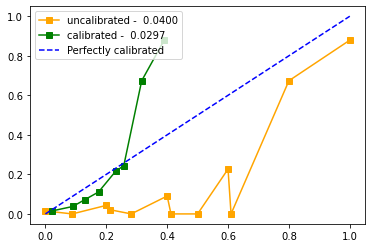

In [18]:
plot_calibration_curve(y_test, dt_result['prediction'], dt_result['cali_prediction'], 20)

In [19]:
def compute_agg_table(rs_df, q, q_col):
    rs_df.quantile(q).loc[:,'pred_prob']
    all_cutoffs = rs_df.quantile(q).loc[:,q_col]

    total_fraud = sum(rs_df['fraud'])


    n_perc = []
    n_fraud = []
    money_saved = []
    p_fraud = []
    false_pos = []
    p_cutoff = []

    for perc, cutoff in zip(all_cutoffs.index, all_cutoffs.values):
    
        pos_mask = rs_df[q_col] >= cutoff
    
        pos_df = rs_df[pos_mask]
        
        n_perc.append(perc)
        n_fraud.append(sum(pos_df['fraud']))
        money_saved.append(sum(pos_df['fraud'] * pos_df['transaction_amount']))
        p_fraud.append(sum(pos_df['fraud']) / total_fraud)
        false_pos.append(len(pos_df) - sum(pos_df['fraud']))
        p_cutoff.append(cutoff)

    agg_df = pd.DataFrame()
    agg_df['percentile'] = n_perc
    agg_df['cutoff'] = p_cutoff
    agg_df['no_of_fraud'] = n_fraud
    agg_df['fraud_money_value'] = money_saved
    agg_df['total_amount'] = [sum(rs_df['transaction_amount'])] * len(n_perc)
    agg_df['percent_fraud'] = p_fraud
    agg_df['u_2fa'] = false_pos
    
    return agg_df


def generate_result_table(cali_y_pred, y_pred,X, y, q = np.array(range(75,100))/100, q_col = 'pred_prob'):
    result_df = pd.DataFrame()
    result_df['fraud'] = y
    result_df['transaction_amount'] = X['TransactionAmt']
    result_df['pred_prob'] = cali_y_pred
    result_df['risk'] = result_df['transaction_amount'] * result_df['pred_prob']
    result_df['uncalibrated_pred_prob'] = y_pred
    
    agg_df = compute_agg_table(result_df, q, q_col)

    return result_df, agg_df

In [20]:
rs_df, ag_df = generate_result_table(dt_result['cali_prediction'], dt_result['prediction'], x_test, y_test)

In [21]:
ag_df.to_csv('ag_dt.csv', index=False)

In [22]:
rs_df['uncalibrated_pred_prob'] = dt_result['prediction']
rs_df.to_csv('dt_output.csv', index = False)